Copyright **`(c)`** 2023 Florentin-Cristian Udrea `<udrea.florentin00@gmail.com>` 

[`https://github.com/florentin1304/computational-intelligence`](https://github.com/florentin1304/computational-intelligence)

# LAB10

Use reinforcement learning to devise a tic-tac-toe player.

### Deadlines:

* Submission: [Dies Natalis Solis Invicti](https://en.wikipedia.org/wiki/Sol_Invictus)
* Reviews: [Befana](https://en.wikipedia.org/wiki/Befana)

Notes:

* Reviews will be assigned  on Monday, December 4
* You need to commit in order to be selected as a reviewer (ie. better to commit an empty work than not to commit)

# Requirements and imports

After installing the requirements file a restart of the kernel may be needed for the install to take place!

In [28]:
# pip install -r requirements.txt

In [29]:
import gym_TicTacToe
import gym
import numpy as np
from IPython.display import clear_output
from agent import TicTacToeAgent
import tqdm
import matplotlib.pyplot as plt


# Agent Training 
The agent was trained for 1'000'000 episodes, in which it was randomly chosen which opponent he will be against and it was also randomly choosen who will start the game.

#### Enemy player

The enemy player is considered part of the environment. After every move of the agent, the gym makes the enemy move implicitly. During training two types of agents were employed

* __Random player__: In this case the enemy player is simply a random player that always chooses one of the valid moves left.
* __Magic Square player__: This player always tries to win. Using the magic square it understands when the opponent is about to win and blocks it and if he is about to win he takes the right action. If he is not in any of the precedent two conditions he tries to take the central spot. If the state is not in any of the situations previously described he simply takes a random action.

#### Epsilon policy
It will balance the exploration-eploitation tradeoff by using a $\epsilon$-greedy policy. The $\epsilon$ is decaying as follows:

$$ \epsilon = {b \over b + ep_{n}} $$

Where b is a constant that depends on the minimum $\epsilon_{min}$ desired and the episode at which the minimum $\epsilon$ is wanted to be encountered at ($ep_n^*$), described as follows:

$$ b = { \epsilon_{min} \over (1 - \epsilon_{min})} ep_n^* $$

In this case $ep_n^*$ was choosen to be the last episode of the training, so $ep_n^* = 1'000'000$.


In [30]:
# initialize the tictactoe environment
env = gym.envs.make("TTT-v0", small=-0.1, large=20)

In [31]:
episodes = 1_000_000
agent = TicTacToeAgent(num_of_actions=env.action_space.n, 
                        gamma=0.98, 
                        lr=0.01, 
                        epsilon_min=0.05, 
                        epsilon_min_episode_reached=episodes)
agent.train()
test = False
talk_every = 5000

ep_rewards, epl_avg, epsilon_hist = [], [], []
wins, loses, draws, illegal = [], [], [], []

for ep in tqdm.tqdm(range(episodes)):
    state, info, done, steps = *env.reset(adversary_first=np.random.choice([True, False]), \
                                          enemy_agent=np.random.choice(["random", "magic_square"])), False, 0
    
    agent.update_epsilon(ep)
    turn = 0
    sum_reward = 0
    
    while not done:
        action = agent.get_action(state)
        new_state, reward, done, info = env.step(action)

        if not test:
            agent.learn(state, action, new_state, reward, done)#, talk=(done and reward>0))
        else:
            env.render()

            
        state = new_state
        sum_reward += reward
        steps += 1

    ep_rewards.append(sum_reward)
    epl_avg.append(np.mean(ep_rewards[ max(0, ep-talk_every) : ]))
    epsilon_hist.append(agent.epsilon)
    
    
    wins.append(1 if info["ending"] == "win" else 0)
    loses.append(1 if info["ending"] == "lose" else 0)
    draws.append(1 if info["ending"] == "draw" else 0)
    illegal.append(1 if info["ending"] == "illegal" else 0)

    if (ep+1) % talk_every == 0:
        clear_output(wait=True)
        print("="*17, "Training resume", "="*17)
        print(f"Episode {ep+1}, average reward: { np.mean(ep_rewards[max(0, ep-talk_every):]) :.2f}")
        print(f"Epsilon: {agent.epsilon:.4}")
        print(f"Len QTable: {len(agent.q_table)}")

        print("="*19, "Percentiles", "="*19)
        print(f"{'wins':^10} | {'losses':^10} | {'draws':^10} | {'illegal':^10}")
        print(f"{((np.sum(wins[max(0, ep-talk_every):])/talk_every) * 100):^10.4} | ", end="")
        print(f"{((np.sum(loses[max(0, ep-talk_every):])/talk_every) * 100):^10.4} | ", end="")
        print(f"{((np.sum(draws[max(0, ep-talk_every):])/talk_every) * 100):^10.4} | ", end="")        
        print(f"{((np.sum(illegal[max(0, ep-talk_every):])/talk_every) * 100):^10.4}")
        print("="*51, end='\r', flush=True)

agent.q_table.save_csv("agent_qtable.csv")

================= Training resume =================
Episode 1000000, average reward: 10.36
Epsilon: 0.05
Len QTable: 5466
=================== Percentiles ===================
   wins    |   losses   |   draws    |  illegal  
  63.24    |    2.32    |   27.18    |    7.28   


100%|██████████| 1000000/1000000 [10:31<00:00, 1584.11it/s]


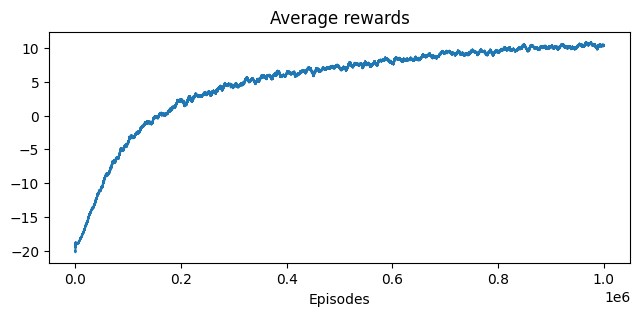

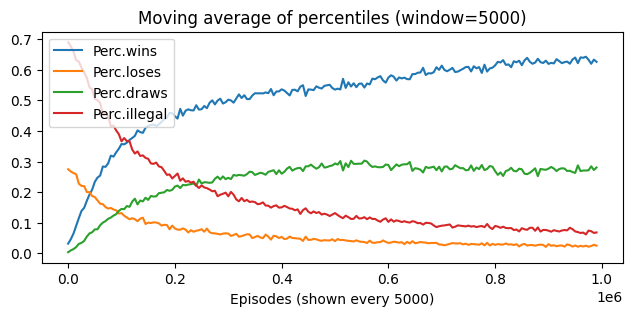

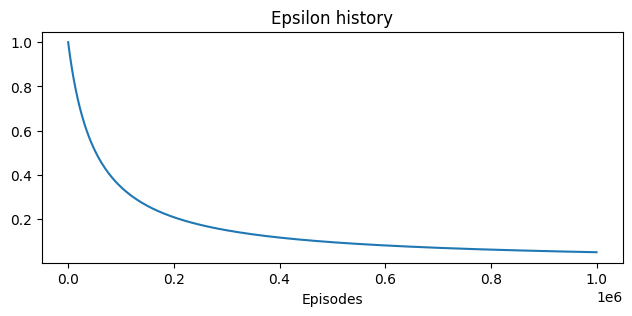

In [32]:
s = 5000
def moving_average(x, window=5000, skip=5000):
    x_sma = [np.sum(x[i-window: i])/window for i in range(window, len(x), skip)]
    return np.array(x_sma)

wins_sma = moving_average(wins, window=s, skip=s)
loses_sma = moving_average(loses, window=s, skip=s)
draws_sma = moving_average(draws, window=s, skip=s)
illegal_sma = moving_average(illegal, window=s, skip=s)


plt.rcParams['figure.figsize'] = (7.5, 3)

plt.xlabel("Episodes")
plt.title("Average rewards")
plt.plot(epl_avg, label="Average rewards")
plt.show()

plt.xlabel(f"Episodes (shown every {s})")
plt.title(f"Moving average of percentiles (window={s})")
plt.plot([i*s for i in range(len(wins_sma))], wins_sma, label="Perc.wins")
plt.plot([i*s for i in range(len(wins_sma))],loses_sma, label="Perc.loses")
plt.plot([i*s for i in range(len(wins_sma))],draws_sma, label="Perc.draws")
plt.plot([i*s for i in range(len(wins_sma))],illegal_sma, label="Perc.illegal")
plt.legend()
plt.show()

plt.xlabel("Episodes")
plt.title("Epsilon history")
plt.plot(epsilon_hist, label="")
plt.show()


# Agent Testing

After the training is done, a file `agent_qtable.csv` is created. It contains the optimal q-table found during the training.

If the agent has to be tested (or deployed in any other way) the following two lines of code have to be executed:

`agent.q_table.load_csv("agent_qtable.csv")`

`agent.test()`

Where the first loads the optimal q-values in the agent's q-table, while the second puts the agent in test mode, meaning it will always take the greedy action, no mather the current epsilon.

In [39]:
episodes = 10000
agent = TicTacToeAgent(num_of_actions=env.action_space.n)
agent.q_table.load_csv("agent_qtable.csv")
agent.test()
test = False
talk_every = 1000

test_ep_rewards, test_epl_avg = [], []

wins_t, loses_t, draws_t, illegal_t = [], [], [], []
for ep in tqdm.tqdm(range(episodes)):
    adversary_first = False #np.random.choice([True, False])
    adversary_agent = "random" #np.random.choice(["random", "magic_square", "trained"])
    trained_file = "agent_qtable_onlyvsrandom.csv"
    state, info, done, steps = *env.reset(adversary_first=adversary_first, \
                                          enemy_agent=adversary_agent, \
                                            file=trained_file if adversary_agent=="trained" else None), False, 0
    
    # print(f"adv first {adversary_first}")
    agent.update_epsilon(ep)
    turn = 0
    sum_reward = 0
    
    while not done:
        action = agent.get_action(state)
        new_state, reward, done, info = env.step(action)
        state = new_state
        sum_reward += reward
        steps += 1
        
        # print(info)
    # input()
    test_ep_rewards.append(sum_reward)
    test_epl_avg.append(np.mean(test_ep_rewards[ max(0, ep-talk_every) : ]))
    
    
    wins_t.append(1 if info["ending"] == "win" else 0)
    loses_t.append(1 if info["ending"] == "lose" else 0)
    draws_t.append(1 if info["ending"] == "draw" else 0)
    illegal_t.append(1 if info["ending"] == "illegal" else 0)

    if (ep+1) % talk_every == 0:
        clear_output(wait=True)
        print("="*23, "Testing resume", "="*22)
        print(f"Episode {ep+1}, average reward: { np.mean(test_ep_rewards[max(0, ep-talk_every):]) :.2f}")

        print("="*24, "Percentiles", "="*24)
        print(f"{'wins':^10} | {'losses':^10} | {'draws':^10} | {'illegal':^10}")
        print(f"{((np.sum(wins_t[max(0, ep-talk_every):])/talk_every) * 100):^10.4} | ", end="")
        print(f"{((np.sum(loses_t[max(0, ep-talk_every):])/talk_every) * 100):^10.4} | ", end="")
        print(f"{((np.sum(draws_t[max(0, ep-talk_every):])/talk_every) * 100):^10.4} | ", end="")        
        print(f"{((np.sum(illegal_t[max(0, ep-talk_every):])/talk_every) * 100):^10.4}")
        print("="*61, end='\r', flush=True)

clear_output(wait=False)

print("="*19, "Testing results", "="*18)
print(f"Average reward: {np.mean(test_ep_rewards)}")
print("="*50)
print(f"{'wins':^10} | {'losses':^10} | {'draws':^10} | {'illegal':^10}")
print(f"{(np.mean(wins_t) * 100):^10.4} | ", end="")
print(f"{(np.mean(loses_t) * 100):^10.4} | ", end="")
print(f"{(np.mean(draws_t) * 100):^10.4} | ", end="")        
print(f"{(np.mean(illegal_t) * 100):^10.4}")
print("="*50)



=================== Testing results ==================
Average reward: 19.258419999999994
   wins    |   losses   |   draws    |  illegal  
  98.11    |    0.0     |    1.89    |    0.0    


# Game display

In [34]:
adversary_first = np.random.choice([True, False])
adversary_agent = "trained"
print(f"{adversary_first=}")
state, info, done, steps = *env.reset(adversary_first=adversary_first, \
                                      enemy_agent=adversary_agent, \
                                      file="agent_qtable_vsboth.csv" if adversary_agent=="trained" else None), False, 0
print(env.render())

turn = 0
sum_reward = 0

while not done:
    action = agent.get_action(state)
    new_state, reward, done, info = env.step(action)
    state = new_state
    sum_reward += reward
    steps += 1
    print(env.render())

adversary_first=False
╒═══╤═══╤═══╕
│ - │ - │ - │
├───┼───┼───┤
│ - │ - │ - │
├───┼───┼───┤
│ - │ - │ - │
╘═══╧═══╧═══╛
╒═══╤═══╤═══╕
│ O │ - │ - │
├───┼───┼───┤
│ - │ X │ - │
├───┼───┼───┤
│ - │ - │ - │
╘═══╧═══╧═══╛
╒═══╤═══╤═══╕
│ O │ - │ - │
├───┼───┼───┤
│ - │ X │ - │
├───┼───┼───┤
│ O │ - │ X │
╘═══╧═══╧═══╛
╒═══╤═══╤═══╕
│ O │ - │ - │
├───┼───┼───┤
│ X │ X │ O │
├───┼───┼───┤
│ O │ - │ X │
╘═══╧═══╧═══╛
╒═══╤═══╤═══╕
│ O │ X │ - │
├───┼───┼───┤
│ X │ X │ O │
├───┼───┼───┤
│ O │ O │ X │
╘═══╧═══╧═══╛
╒═══╤═══╤═══╕
│ O │ X │ X │
├───┼───┼───┤
│ X │ X │ O │
├───┼───┼───┤
│ O │ O │ X │
╘═══╧═══╧═══╛
